In [3]:
import os, json, sys, gzip, pickle
sys.path.append('../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde
from src.utils import MetalElements, LigandElements, ActiveElements, AllElements
from src.feature import active_composit_feature
#from src.data import composition_to_feature, feature_to_composition
from pymatgen.core import Element

data_root = '/home/jhyang/WORKSPACES/DATA/synthesis/SynthesisSimilarity/rsc'
os.listdir(data_root)

['ele_order_counter.json',
 'pre_count_normalized_by_rxn_ss.json',
 'data_split.npz',
 'reactions_v20_20210820_ss.jsonl']

# Raw file parsing

- raw data file

In [5]:
# raw json file
with open(f'{data_root}/reactions_v20_20210820_ss.jsonl') as f:
    full_data = [json.loads(l) for l in list(f)]

i = np.random.randint(len(full_data))

_data = full_data[36728]

#for _data in full_data:
#    if _data['doi'] != '10.1103/physrevb.95.054430':
#        continue

def print_data(dat):
    for key in ['material_string','material_formula']:
        print(key, '\t:', dat[key])
    for _d in dat['composition']:
        print('\t', _d['formula'], '/', _d['elements'])
print(i, _data['doi'])
print_data(_data['target'])
print()
for _prec in _data['precursors']: print_data(_prec)

35616 10.1111/jace.17226
material_string 	: (Nb1/3Ta1/3Ti1/3)N1-δ
material_formula 	: (Nb1/3Ta1/3Ti1/3)N1-δ
	 (Nb1/3Ta1/3Ti1/3)N1-δ / {'Nb': '0.333', 'Ta': '0.333', 'Ti': '0.333', 'N': '1-δ'}

material_string 	: NbN
material_formula 	: NbN
	 NbN / {'Nb': '1', 'N': '1'}
material_string 	: TaN
material_formula 	: TaN
	 TaN / {'Ta': '1', 'N': '1'}
material_string 	: titanium nitride
material_formula 	: Ti3N4
	 Ti3N4 / {'Ti': '3', 'N': '4'}
material_string 	: niobium nitride
material_formula 	: Nb3N5
	 Nb3N5 / {'Nb': '3', 'N': '5'}


- raw numpy file

In [6]:
# raw numpy file
npz_data = {k:v for k,v in np.load(f'{data_root}/data_split.npz', allow_pickle=True).items()}

- check data

In [7]:
# check 
for ds_rxn, ds in npz_data.items():
    for i, data in enumerate(ds):
#        n = (d['target_comp'][0] != d['target_comp_featurized'][0]).sum()
        chem = data['prototype_path'][0].split('/')[-1]
        if data['doi'] == '10.1016/j.actamat.2006.08.010':
            print(ds_rxn, i)
            for prot in data['prototype_path']:
                print(prot.split('/')[4:])

train_reactions 8866
['Mg0.3Nb0.7PbO3', 'NoDoping', 'Mg0.333Nb0.66699994Pb1O3', 'Mg0.333Nb0.66699994Pb1O3']


In [8]:
import re

re_spec = re.compile(r'\d+(\.\d+)?')
re_ele = re.compile(r'[A-Z][a-z]?')
print(chem)
chem = data['prototype_path'][0].split('/')[-1]
ns = [float(m.group()) for m in re_spec.finditer(chem)]
eles = [m.group() for m in re_ele.finditer(chem)]
print(eles, ns)
#comp = dat['target_comp'][0]
#m = comp != 0
#
#for i in np.where(m)[0]:
#    print(i, comp[i])

Ta0.1665833Ti0.1665833Nb0.1665833N0.50025016
['Ta', 'Ti', 'Nb', 'N'] [0.1665833, 0.1665833, 0.1665833, 0.50025016]


In [9]:
for ds_rxn, ds in npz_data.items():
    for i, data in enumerate(ds):
        if len(data['target_comp']) != 1:
            print(ds_rxn, i, data['raw_id'])

# Parsing data

## raw file

- Changing composition vector to composition dictionary
- Unfiying temperature and time scales

In [10]:
ele_dict = {i:{} for i in range(100)}
#for d in npz_data['test_reactions']:
units = {'temp':{}, 'time':{}}
for ds_rxn, dataset in npz_data.items():
    for i, data in enumerate(dataset):
        chem = data['prototype_path'][0].split('/')[-1]
        if '(' in chem: continue
        ns = [float(m.group()) for m in re_spec.finditer(chem)]
        eles = [m.group() for m in re_ele.finditer(chem)]
        if len(eles) != len(ns): continue
        comp = data['target_comp'][0]
        idxs = np.where(comp != 0)[0]
#        print(chem)
#        print(eles)
#        print(ns)
#        print(comp[idxs] * np.sum(ns))
    #    print(idxs)
        for n, ele in zip(ns, eles):
            j = np.where(np.abs(comp[idxs] * np.sum(ns) - n) < 1e-3)[0]
            if len(j) != 1:
                continue
            k = idxs[j[0]]
#            print(ele, j[0], idxs[j[0]])
            if ele not in ele_dict[k].keys():
                ele_dict[k][ele] = 0
            ele_dict[k][ele] += 1
#            if ele_dict[k][ele] < 15:
#                ele_dict[k]['ids'].append(data['doi'])
        for op in data['operations']:
            for temp in op['attributes']['temperature']:
                unit = temp['units']
                if unit not in units['temp'].keys():
                    units['temp'][unit] = 0
                units['temp'][unit] +=1
            for time in op['attributes']['time']:
                unit = time['units']
                if unit not in units['time'].keys():
                    units['time'][unit] = 0
                units['time'][unit] +=1
                

In [11]:
ele_mapper = {}
ele_indexer = [v for k,v in ele_dict.items()]
for k, v in ele_dict.items():
    if len(v.keys()) == 1:
        ele = list(v.keys())[0]
        ele_mapper[ele] = k
        ele_indexer[k] = ele

print(json.dumps(ele_dict, indent=4))
print(json.dumps(ele_mapper, indent=4))
#with open('../dump/ele_mapper.json','w') as f:
#    json.dump(ele_mapper, f, indent=4)

{
    "0": {
        "Cs": 87
    },
    "1": {
        "K": 70
    },
    "2": {
        "Rb": 24
    },
    "3": {
        "Ba": 4731
    },
    "4": {
        "Na": 1774
    },
    "5": {
        "Sr": 4884
    },
    "6": {
        "Li": 2728
    },
    "7": {
        "Ca": 4139
    },
    "8": {
        "La": 4719
    },
    "9": {
        "Tb": 466
    },
    "10": {
        "Yb": 475
    },
    "11": {
        "Ce": 1632
    },
    "12": {
        "Pr": 629
    },
    "13": {
        "Nd": 822
    },
    "14": {
        "Sm": 747
    },
    "15": {
        "Eu": 1396
    },
    "16": {
        "Gd": 1048
    },
    "17": {
        "Dy": 402
    },
    "18": {
        "Y": 2272
    },
    "19": {
        "Ho": 214
    },
    "20": {
        "Er": 267
    },
    "21": {
        "Tm": 56
    },
    "22": {
        "Lu": 330
    },
    "23": {
        "Pu": 17
    },
    "24": {
        "Am": 2
    },
    "25": {
        "Cm": 1
    },
    "26": {
        "Hf": 158
    },
    "27": 

In [12]:
#units
unit_convertors = {
    '°C': lambda x: x + 273.15,
    'C': lambda x: x + 273.15,
    'K': lambda x: x,
    'h': lambda x: x,
    'hours': lambda x: x,
    'min': lambda x: x/60,
    'day': lambda x: x * 24,
    'minutes': lambda x: x/60,
    'hr': lambda x: x,
    'd': lambda x: x * 24,    
    'hrs': lambda x: x,
    'hour': lambda x: x,
}

In [13]:
import copy

#parsed_data = {}
raw_data = []
weights = []
for k, dataset in npz_data.items():
#    parsed_data[k] = []
    for data in dataset:
        _data = {}
        for key in ['id', 'raw_index', 'synthesis_type', 'doi', 'year', 'prototype_path', 'count_weight']:
            _data[key] = copy.deepcopy(data[key])
        #weights.append(data['count_weight'])
        #print(data['doi'], data['count_weight'])
        target_vec = data['target_comp'][0]
        target_comp = {ele_indexer[i]:target_vec[i] for i in np.where(target_vec)[0]}
        precursors = []
        for preccursor_vec in data['precursors_comp']:
            precursor_vec = preccursor_vec[0]
            precursor_comp = {ele_indexer[i]:precursor_vec[i] for i in np.where(precursor_vec)[0]}
            precursors.append(precursor_comp)
        _data['target_comp'] = target_comp
        _data['precursor_comp'] = precursors
        operations = []
        prev_op = None
        num_val = 0
        for op in data['operations']:
            check = False
            _op = {'type': op['type'], 'string': op['string'], 
                   'attributes':{
                       'temperature':[], 'time':[], 'env':[]
                   }}
            for attr_type in ['temperature','time']:
                for attr in op['attributes'][attr_type]:
                    _unit_converter = unit_convertors[attr['units']]
                    _min = attr['min']
                    _max = attr['max']
                    _val = attr['values'] + [_min, _max]
                    _val = sorted([_unit_converter(v) for v in set(_val) if v is not None])
                    if attr_type == 'temperature':
                        _val = [_v for _v in _val if (_v < 4000) and (_v > 0)]
                    if len(_val) == 0:
                        continue
                    _op['attributes'][attr_type].append({
                        'min':np.min(_val),
                        'max':np.max(_val),
                        'values': _val,
                        'unit':'K' if 'temp' in attr_type else 'h',
                    })
                    num_val += 1
                    if len(_val) > 3:
                        check = True
            for env in op['attributes']['environment']:
                if env == '':
                    continue
                _op['attributes']['env'].append(env)
                num_val += 1
            if num_val == 0:
                continue
            operations.append(_op)
#            if check: print(json.dumps(_op, indent=4))
        _data['operations'] = operations
#        parsed_data[k].append(_data)
        raw_data.append(_data)

In [14]:
with gzip.open('../data/raw_data.pkl.gz','wb') as f:
    pickle.dump(raw_data, f)

## collects unique dataset

In [2]:
with gzip.open('../data/raw_data.pkl.gz','rb') as f:
    raw_data = pickle.load(f)

In [8]:
unique_target_data = []
unique_prec_data = []

target_vecs = np.zeros((1,104))
prec_vecs = np.zeros((1,104))
prec_sum_vecs = []
new_idx = 0
for i, data in enumerate(sorted(raw_data, key=lambda x: x['year'])):
    target_vec = active_composit_feature(data['target_comp'], float)
    dist = np.abs(target_vecs - target_vec).sum(1)
    is_unique = np.sum(dist < 1e-5) == 0
    _temp = []
    _time = []
    for op in data['operations']:
        if not op['type'].startswith('Heating'): continue
        for t in op['attributes']['temperature']:
            _temp.extend(t['values'])
        for t in op['attributes']['time']:
            _time.extend(t['values'])
    if is_unique:
        target_vecs = np.vstack([target_vecs, target_vec])
        unique_target_data.append({
            'id':new_idx,
            'raw_id':data['id'],
            'year':data['year'],
            'count':1,
            'target_comp':data['target_comp'],
            'precursors':[{
                'count':1,
                'years':[data['year']],
                'precursor_comp':data['precursor_comp'],
                'heat_temp':_temp,
                'heat_time':_time,
            }],
        })    
        prec_sum_vecs.append(np.sum([active_composit_feature(p, float) for p in data['precursor_comp']],0).reshape(1,-1))
        new_idx += 1
    else:
        j = np.argmin(dist) - 1
        unique_target_data[j]['count'] += 1
        prec_sum_vec = np.sum([active_composit_feature(p, float) for p in data['precursor_comp']], 0)
        pdist = np.abs(prec_sum_vecs[j] - prec_sum_vec).sum(1)
        is_prec_unique = np.sum(pdist < 1e-5) == 0
        if is_prec_unique:
            prec_sum_vecs[j] = np.vstack([prec_sum_vecs[j], prec_sum_vec])
            unique_target_data[j]['precursors'].append({
                'count':1,
                'years':[data['year']],
                'precursor_comp':data['precursor_comp'],
                'heat_temp':_temp,
                'heat_time':_time,
            })
        else:
            k = np.argmin(pdist)
            unique_target_data[j]['precursors'][k]['count'] += 1
            unique_target_data[j]['precursors'][k]['years'].append(data['year'])
            unique_target_data[j]['precursors'][k]['heat_temp'].extend(_temp)
            unique_target_data[j]['precursors'][k]['heat_time'].extend(_time)

    # find unique precursors
    for prec_comp in data['precursor_comp']:
        prec_vec = active_composit_feature(prec_comp, float)
        dist = np.abs(prec_vec - prec_vecs).sum(1)
        is_unique = np.sum(dist < 1e-5) == 0
        if is_unique:
            prec_vecs = np.vstack([prec_vecs, prec_vec])
            unique_prec_data.append({
                'years':[data['year']],
                'precursor_comp':prec_comp,
            })
        else:
            j = np.argmin(dist) - 1
            unique_prec_data[j]['years'].append(data['year'])
    print(i, target_vecs.shape, prec_vecs.shape, end='\r')

In [9]:
with gzip.open('../data/unique_target.pkl.gz','wb') as f:
    pickle.dump(unique_target_data, f)
with gzip.open('../data/unique_precursor.pkl.gz','wb') as f:
    pickle.dump(unique_prec_data, f)

- check

In [8]:
target_comp = {'Fe': 0.2857143, 'Ni': 0.14285715, 'O': 0.5714286}
target_vec = active_composit_feature(target_comp, float)
data_collection = []
for i, data in enumerate(raw_data):
    vec = active_composit_feature(data['target_comp'], float)
    if np.abs(target_vec - vec).sum() < 5e-5:
        data_collection.append(data)

In [9]:
pvecs = np.zeros((1,104))
dump_0 = []
for d in data_collection:
    pvec = np.sum([active_composit_feature(p, float) for p in d['precursor_comp']], 0)
    dist = np.abs(pvecs - pvec).sum(1)
    is_unique = np.sum(dist < 5e-5) == 0
    if is_unique:
        pvecs = np.vstack([pvecs, pvec])
        dump_0.append({'comp':d['precursor_comp'], 'path':[d['prototype_path']]})
    else:
        dump_0[np.argmin(dist) - 1]['path'].append(d['prototype_path'])
        
for d in dump_0:
    print(d['comp'])
    for p in d['path']:
        print(p)

[{'Ni': 0.4, 'O': 0.6}, {'Fe': 0.4, 'O': 0.6}]
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
[{'Ni': 1.0}, {'Fe': 0.4, 'O': 0.6}]
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
[{'Fe': 0.4, 'O': 0.6}, {'Ni': 0.5, 'O': 0.5}]
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/oxides/ternary/Others/Misc/Fe1.5Ni0.75O3/Fe1.5Ni0.75O3']
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/o

### ligands

In [6]:
with gzip.open('../data/unique_precursor.pkl.gz','rb') as f:
    unique_precursor = pickle.load(f)

unique_ligand = {}
for prec in unique_precursor:
    n = len(prec['years'])
    metals = {}
    ligands = {}
    for e, f in prec['precursor_comp'].items():
        if e in MetalElements:
            metals.update({e:f})
        else:
            ligands.update({e:f})
    k_m = tuple(sorted(list(metals.keys()), key=lambda x: Element(x).number))
    k_l = tuple(sorted(list(ligands.keys()), key=lambda x: Element(x).number))
    if k_l not in unique_ligand.keys():
        unique_ligand[k_l] = {'count':0, 'metals':{}}
    if k_m not in unique_ligand[k_l]['metals']:
        unique_ligand[k_l]['metals'][k_m] = {
            'count':0, 'case':[]
        }
    unique_ligand[k_l]['count'] += n
    unique_ligand[k_l]['metals'][k_m]['count'] += n
    unique_ligand[k_l]['metals'][k_m]['case'].append({
        'composition':prec['precursor_comp'], 'years':prec['years']}
    )

In [7]:
unique_ligand

{('O',): {'count': 86539,
  'metals': {('Y',): {'count': 3101,
    'case': [{'composition': {'Y': 0.4, 'O': 0.6},
      'years': [1979,
       1979,
       1986,
       1995,
       1995,
       1996,
       1996,
       1996,
       1996,
       1997,
       1997,
       1997,
       1997,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       2000,
       2000,
       2000,
       2000,
       2000,
       2000,
       2000,
      

In [8]:
with gzip.open('../data/unique_ligand.pkl.gz','wb') as f:
    pickle.dump(unique_ligand, f)

# Parsed dataset

In [12]:
n_train = 44736
n_valid = 2254
with gzip.open('../data/raw_data.pkl.gz','rb') as f:
    raw_data = pickle.load(f)
    
parsed_data = {
    'train_reactions':raw_data[:n_train],
    'valid_reactions':raw_data[n_train:n_train+n_valid],
    'test_reactions':raw_data[n_train+n_valid:],
}
with gzip.open('../data/unique_target.pkl.gz','rb') as f:
    unique_target = pickle.load(f)

with gzip.open('../data/unique_precursor.pkl.gz','rb') as f:
    unique_precursor = pickle.load(f)

with gzip.open('../data/unique_ligand.pkl.gz','rb') as f:
    unique_ligand = pickle.load(f)

In [5]:
for k, dataset in parsed_data.items():
    print(k, len(dataset))

train_reactions 44736
valid_reactions 2254
test_reactions 2934


In [39]:
parsed_data['train_reactions'][40000]

{'id': 14897,
 'raw_index': 10710,
 'synthesis_type': 'solid_state_ceramic_synthesis',
 'doi': '10.1016/j.materresbull.2017.12.054',
 'year': 2018,
 'prototype_path': ['AllMaterials/oxides/ternary/ABO3/BaTiO3/SubBa<-Sr,Ti<-Zr/Ba0.89999998Sr0.09999999Zr0.09999999Ti0.89999998O3/Ba0.89999998Sr0.09999999Zr0.09999999Ti0.89999998O3'],
 'count_weight': 1.0,
 'target_comp': {'Ba': 0.17999999,
  'Sr': 0.02,
  'Zr': 0.02,
  'Ti': 0.17999999,
  'O': 0.6},
 'precursor_comp': [{'Ba': 0.2, 'C': 0.2, 'O': 0.6},
  {'Ti': 0.33333334, 'O': 0.6666667},
  {'Zr': 0.33333334, 'O': 0.6666667},
  {'Sr': 0.2, 'C': 0.2, 'O': 0.6}],
 'operations': [{'type': 'HeatingOperation',
   'string': 'calcined',
   'attributes': {'temperature': [{'min': 1323.15,
      'max': 1323.15,
      'values': [1323.15],
      'unit': 'K'}],
    'time': [{'min': 4.0, 'max': 4.0, 'values': [4.0], 'unit': 'h'}],
    'env': []}},
  {'type': 'HeatingOperation',
   'string': 'sintering',
   'attributes': {'temperature': [{'min': 1473.15,


## Stat

In [13]:
years = []
target_elements = []
prec_elements = []
for dataset in parsed_data.values():
    y = []
    for data in dataset:
        vec = np.zeros(104)
        y.append(data['year'])
        for e, f in data['target_comp'].items():
            vec[Element(e).number] = f
        target_elements.append(vec != 0)
        for prec_comp in data['precursor_comp']:
            vec = np.zeros(104)
            for e, f in prec_comp.items():
                vec[Element(e).number] = f
            prec_elements.append(vec != 0)
    print(len(y), np.min(y), np.max(y)) # year range is wired
    years.extend(y)
years = np.array(years)
target_elements = np.array(target_elements).T
prec_elements = np.array(prec_elements).T

44736 1979 2020
2254 2015 2020
2934 2017 2020


(1978.0, 2021.0)

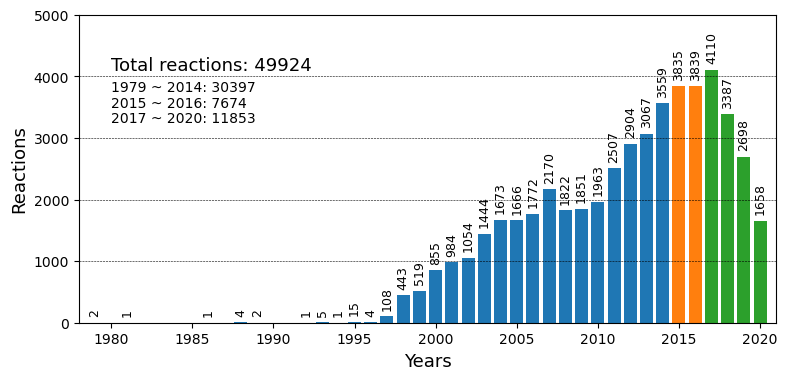

In [128]:
f, ax = plt.subplots(1,1,figsize=(9,4))
total = [0,0,0]
for y in range(years.min(), years.max()+1):
    n = np.sum(years == y)
    if n == 0: continue
    if y < 2015:
        ax.bar(y, n, color=mpl.cm.tab10(0))
        total[0] += n
    elif y < 2017:
        ax.bar(y, n, color=mpl.cm.tab10(1))
        total[1] += n
    else:
        ax.bar(y, n, color=mpl.cm.tab10(2))
        total[2] += n
    ax.text(y, n + 100, f'{n:.0f}', rotation=90, fontsize=9,
            horizontalalignment='center', verticalalignment='bottom')
for i in range(1,5):
    ax.axhline(i*1000, ls='--', color='k', lw=0.4)
ax.set_ylabel('Reactions', fontsize=13)
ax.set_xlabel('Years', fontsize=13)
ax.text(1980, 3700+400, f'Total reactions: {len(years)}', fontsize=13)
ax.text(1980, 3450+300, f'1979 ~ 2014: {total[0]}', fontsize=10)
ax.text(1980, 3200+300, f'2015 ~ 2016: {total[1]}', fontsize=10)
ax.text(1980, 2950+300, f'2017 ~ 2020: {total[2]}', fontsize=10)
ax.set_ylim([0, 5000])
ax.set_xlim([1978, 2021])

(1978.0, 2021.0)

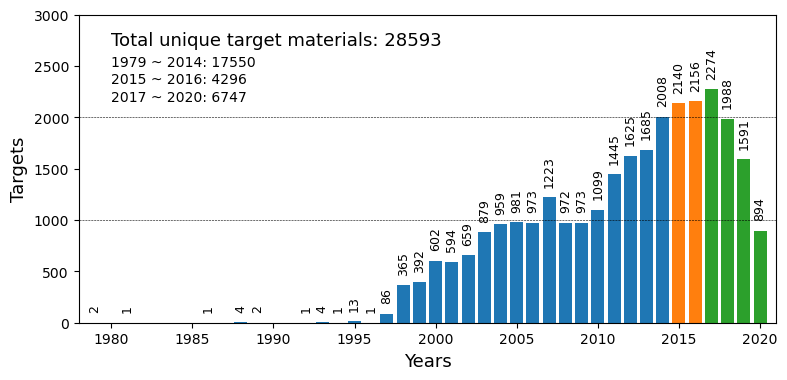

In [6]:
years = np.array([d['year'] for d in unique_target])
f, ax = plt.subplots(1,1,figsize=(9,4))
total = [0,0,0]
for y in range(years.min(), years.max()+1):
    n = np.sum(years == y)
    if n == 0: continue
    if y < 2015:
        ax.bar(y, n, color=mpl.cm.tab10(0))
        total[0] += n
    elif y < 2017:
        ax.bar(y, n, color=mpl.cm.tab10(1))
        total[1] += n
    else:
        ax.bar(y, n, color=mpl.cm.tab10(2))
        total[2] += n
    ax.text(y, n + 100, f'{n:.0f}', rotation=90, fontsize=9,
            horizontalalignment='center', verticalalignment='bottom')
for i in range(1,3):
    ax.axhline(i*1000, ls='--', color='k', lw=0.4)
ax.set_ylabel('Targets', fontsize=13)
ax.set_xlabel('Years', fontsize=13)
ax.text(1980, 2700, f'Total unique target materials: {len(years)}', fontsize=13)
ax.text(1980, 2500, f'1979 ~ 2014: {total[0]}', fontsize=10)
ax.text(1980, 2330, f'2015 ~ 2016: {total[1]}', fontsize=10)
ax.text(1980, 2160, f'2017 ~ 2020: {total[2]}', fontsize=10)
ax.set_ylim([0,3000])
ax.set_xlim([1978, 2021])

In [100]:
for e in sorted(AllElements, key=lambda x: Element(x).number):
    i = Element(e).number
    if i == 104: break
    print(f'{e:2s} : {target_elements[i].sum():5d}')
    

H  :   154
He :     0
Li :  5299
Be :    56
B  :   833
C  :   378
N  :   395
O  : 41800
F  :   656
Ne :     0
Na :  3516
Mg :  3662
Al :  4405
Si :  3858
P  :  2335
S  :  1649
Cl :   469
Ar :     0
K  :   173
Ca :  6419
Sc :   605
Ti :  9939
V  :  1600
Cr :  1459
Mn :  6138
Fe :  7455
Co :  4549
Ni :  3132
Cu :  4550
Zn :  3695
Ga :  2097
Ge :  1201
As :   335
Se :  1323
Br :   101
Kr :     0
Rb :   146
Sr :  7785
Y  :  3286
Zr :  3502
Nb :  4305
Mo :  1739
Tc :     6
Ru :   730
Rh :   175
Pd :   190
Ag :   792
Cd :   393
In :  1183
Sn :  1638
Sb :  1860
Te :  1923
I  :   140
Xe :     0
Cs :   274
Ba :  7849
La :  6758
Ce :  2120
Pr :   921
Nd :  1252
Pm :     0
Sm :  1023
Eu :  1684
Gd :  1652
Tb :   595
Dy :   540
Ho :   317
Er :   348
Tm :    85
Yb :   676
Lu :   525
Hf :   258
Ta :  1436
W  :  1327
Re :    81
Os :    49
Ir :   304
Pt :   101
Au :    80
Hg :    43
Tl :    75
Pb :  2337
Bi :  5498
Po :     0
At :     0
Rn :     0
Fr :     0
Ra :     0
Ac :     0
Th :    49
Pa :     0

- element usage frequency

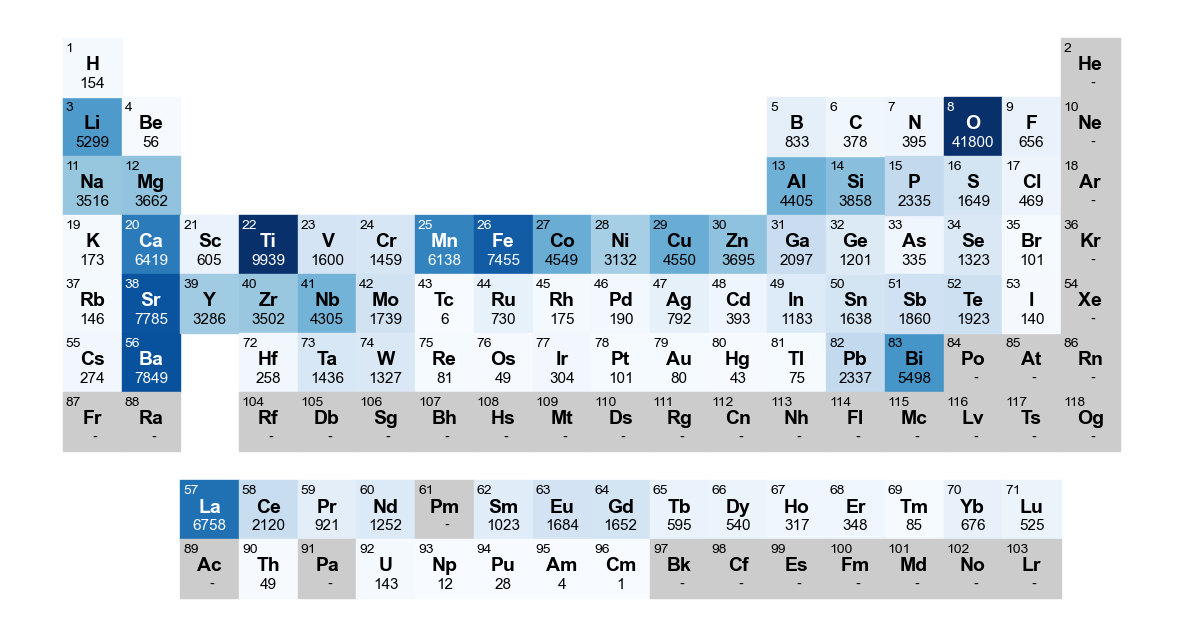

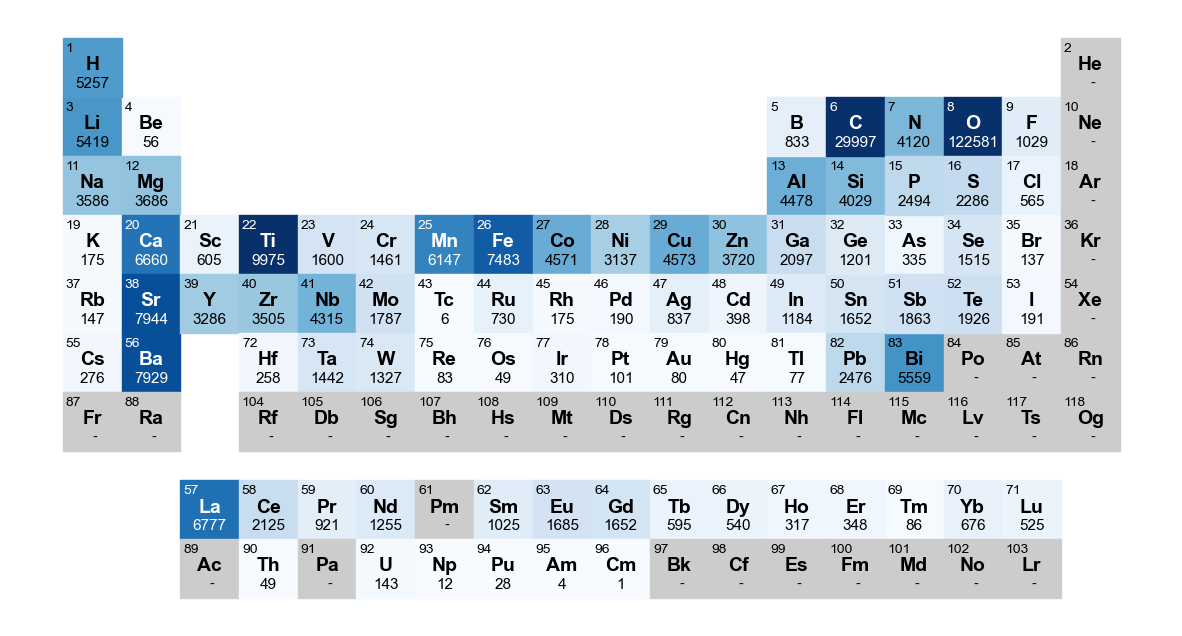

In [14]:
cy = 0
cmap = mpl.cm.Blues
cmap.set_under([0.5,0.5,0.5])
for elements in [target_elements, prec_elements]:
    f, ax = plt.subplots(1,1,figsize=(15,8))
    counter = {(6,3):0, (7,3):0}
    for e in AllElements:
        ele = Element(e)
        x, y = ele.row, ele.group
        z = 0
        if ele.number < 104:
            z = elements[ele.number].sum()
        key = (x,y)
        if key in counter.keys():
            x += 2.5
            y += counter[key]
            counter[key] += 1
        x=-x
    #    print(i, x,y)
        color = [0,0,0]
        if z > 6000: color = [1,1,1]
        if z != 0:
            ax.fill_between([y, y+1], x, x-1, color=cmap(z/9000))
            ax.text(y+0.5, x-0.85, f'{z:.0f}', fontsize=11, fontfamily='arial', color=color, horizontalalignment='center')
        else:
            ax.fill_between([y, y+1], x, x-1, color=[0.8, 0.8, 0.8])
            ax.text(y+0.5, x-0.85, '-')
        ax.text(y+0.05, x-0.24, str(ele.number), fontsize=10, fontfamily='arial', color=color)
        ax.text(y+0.5, x-0.55, e, fontsize=14, fontweight='bold', fontfamily='arial', color=color, horizontalalignment='center')
    ax.axis('off')
    #f.savefig('./figs/ptable.electronegativity.pdf')


In [19]:
element_fractions = {'all':[]}
element_fractions.update({e:[] for e in sorted(AllElements, key=lambda x: Element(x).number)})
for data in raw_data:
    for ele, frac in data['target_comp'].items():
        element_fractions[ele].append(np.log10(frac))
        element_fractions['all'].append(np.log10(frac))

In [28]:
for ele, frac in element_fractions.items():
    if len(frac) == 0: continue
    print('{:5s} {:4d} {:8.2f} {:8.2f}'.format(ele, len(frac), min(frac), max(frac)))
    _f = np.array(frac)
    if np.sum(_f < -3.9) != 0:
        print(' '.join([f'{_n:10.6f}' for _n in np.power(10, _f[_f < -3.9])]))

all   192474    -5.30    -0.00
  0.000125   0.000083   0.000010   0.000005   0.000034   0.000083   0.000111   0.000111   0.000111   0.000111   0.000100   0.000050   0.000083   0.000100   0.000100   0.000100   0.000100   0.000091   0.000088   0.000023   0.000116   0.000091   0.000022   0.000022   0.000122   0.000125   0.000067   0.000125   0.000125   0.000125   0.000100   0.000119   0.000045   0.000095   0.000100   0.000100   0.000101   0.000121   0.000032   0.000034   0.000103   0.000034   0.000103
H      154    -2.25    -0.15
Li    5299    -3.19    -0.09
Be      56    -3.28    -0.03
B      833    -3.00    -0.02
C      378    -3.38    -0.01
N      395    -2.32    -0.25
O     41800    -2.49    -0.08
F      656    -2.85    -0.10
Na    3516    -3.81    -0.12
Mg    3662    -3.70    -0.01
Al    4405    -3.51    -0.00
Si    3858    -3.30    -0.00
P     2335    -2.45    -0.06
S     1649    -2.82    -0.00
Cl     469    -3.05    -0.10
K      173    -2.00    -0.18
Ca    6419    -3.64    -0.04
Sc

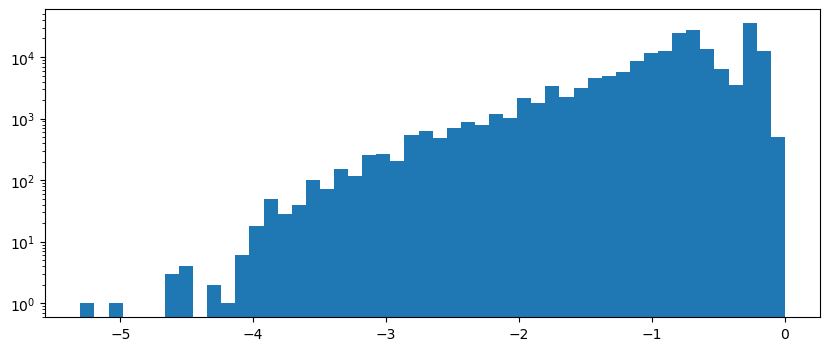

In [25]:
f, ax = plt.subplots(1,1,figsize=(10,4))
ax.hist(element_fractions['all'], bins=50)
ax.set_yscale('log')

- check with prototype path
  - 데이터 구성에 의문점이 많음. prototype_path를 이용해 중복을 제거하면 너무 많은 물질이 제거됨.
  - 제거 후에도 validation data에 2020년 데이터가 남아있기도 함.
  - 따로 제거 방식이 있을 듯 한데....

In [25]:
data_mat = []
for ds, dataset in parsed_data.items():
    ds_key = ds.split('_')[0]
    for data in dataset:
        _d = [ds_key, data['year']] + data['prototype_path'][0].split('/')
        if 'Misc' in _d:
            _d = _d[:6] + ['Misc'] +_d[6:]
        data_mat.append(_d)
df = pd.DataFrame(data_mat)
df.columns = [f'{i:02d}' for i in df.columns]
df = df.sort_values('01')

In [26]:
misc = df[df['06'] == 'Misc']
cat  = df[df['06'] != 'Misc']
for ds in ['train','valid','test']:
    ms0 = misc[misc['00'] == ds]
    ms1 = misc.drop_duplicates(['08'])
    ms1 = ms1[ms1['00'] == ds]
    ms2 = misc.drop_duplicates(['09'])
    ms2 = ms2[ms2['00'] == ds]
    
    cs0 = cat[cat['00'] == ds]
    cs1 = cat.drop_duplicates(['06','07'])
    cs1 = cs1[cs1['00'] == ds]
    cs2 = cat.drop_duplicates(['09'])
    cs2 = cs2[cs2['00'] == ds]
    print(ms0.shape, ms1.shape, ms2.shape)
    print(ms0['01'].min(), ms0['01'].max(), ms1['01'].min(), ms1['01'].max(), ms2['01'].min(), ms2['01'].max())

    print(cs0.shape, cs1.shape, cs2.shape)
    print(cs0['01'].min(), cs0['01'].max(), cs1['01'].min(), cs1['01'].max(), cs2['01'].min(), cs2['01'].max())


(16819, 10) (13282, 10) (13282, 10)
1979 2020 1979 2020 1979 2020
(27917, 10) (4392, 10) (11618, 10)
1988 2020 1988 2020 1988 2020
(1794, 10) (1571, 10) (1571, 10)
2015 2020 2015 2020 2015 2020
(460, 10) (117, 10) (356, 10)
2015 2020 2015 2020 2015 2020
(2619, 10) (2389, 10) (2389, 10)
2017 2020 2017 2020 2017 2020
(315, 10) (71, 10) (276, 10)
2017 2020 2017 2020 2017 2020


In [39]:
df[(df['00'] == 'train')].drop_duplicates('02 03 04 05 06 07 08 09'.split())

,00,01,02,03,04,05,06,07,08,09
0,train,1979,AllMaterials,oxides,quaternary,Others,Misc,Misc,Y0.00200057Al0.05487283Si0.37153473N0.51443273...,Y0.00200057Al0.05487283Si0.37153473N0.51443273...
1,train,1979,AllMaterials,oxides,quaternary,Others,Misc,Misc,Y0.001Al0.05614286Si0.37142855N0.51428568O0.05...,Y0.001Al0.05614286Si0.37142855N0.51428568O0.05...
2,train,1981,AllMaterials,oxides,ternary,Others,Misc,Misc,Zr0.40000001Cr0.80000001O2,Zr0.40000001Cr0.80000001O2
3,train,1986,AllMaterials,oxides,quaternary,Others,Misc,Misc,Na5Y(SiO3)4,Na5Y(SiO3)4
4,train,1988,AllMaterials,oxides,ternary,Others,BaFe12O19,NoDoping,BaFe12O19,BaFe12O19
...,...,...,...,...,...,...,...,...,...,...
43247,train,2020,AllMaterials,oxides,ternary,Others,Fe4Bi2O9,SubBi<-Nd,Nd0.05999999Fe4Bi1.93999994O9,Nd0.05999999Fe4Bi1.93999994O9
43244,train,2020,AllMaterials,oxides,ternary,ABO3,LuMnO3,SubLu<-Y,Y0.30000001Lu0.69999999Mn1O3,Y0.30000001Lu0.69999999Mn1O3
43240,train,2020,AllMaterials,oxides,ternary,Others,Misc,Misc,Ce0.03Fe1.93999994Co1.02999997O4,Ce0.03Fe1.93999994Co1.02999997O4
43239,train,2020,AllMaterials,oxides,ternary,AB2O4,Fe2CoO4,NoDoping,Ce0.02Fe1.95999992Co1.01999998O4,Ce0.02Fe1.95999992Co1.01999998O4


In [108]:
train_mask = df['00'] == 'train'
df_uniq = pd.concat([
    df[train_mask & (df['07'] == 'Misc')], df[train_mask & (df['07'] != 'Misc')].drop_duplicates([f'{i:02d}' for i in range(2,8)])
])
df_uniq

,00,01,02,03,04,05,06,07,08,09
0,train,1979,AllMaterials,oxides,quaternary,Others,Misc,Misc,Y0.00200057Al0.05487283Si0.37153473N0.51443273...,Y0.00200057Al0.05487283Si0.37153473N0.51443273...
1,train,1979,AllMaterials,oxides,quaternary,Others,Misc,Misc,Y0.001Al0.05614286Si0.37142855N0.51428568O0.05...,Y0.001Al0.05614286Si0.37142855N0.51428568O0.05...
2,train,1981,AllMaterials,oxides,ternary,Others,Misc,Misc,Zr0.40000001Cr0.80000001O2,Zr0.40000001Cr0.80000001O2
3,train,1986,AllMaterials,oxides,quaternary,Others,Misc,Misc,Na5Y(SiO3)4,Na5Y(SiO3)4
8,train,1989,AllMaterials,oxides,ternary,Others,Misc,Misc,Tb2Te4O11,Tb2Te4O11
...,...,...,...,...,...,...,...,...,...,...
44485,train,2019,AllMaterials,oxides,quinary,Others,Li6.4La3Zr2Ga0.2O12,SubLa<-Y,Li6.40000057La2.87499976Y0.125Zr2Ga0.20000002O12,Li6.40000057La2.87499976Y0.125Zr2Ga0.20000002O12
44494,train,2019,AllMaterials,oxides,quaternary,Others,Li3Mg2SbO6,SubSb<-Mn,Li3Mg2Mn0.005Sb0.995O6,Li3Mg2Mn0.005Sb0.995O6
44642,train,2015,AllMaterials,chalcogenides,binary,Others,As2Te3,SubAs<-Sn,Sn0.01Te3As1.98999989,Sn0.01Te3As1.98999989
44661,train,2015,AllMaterials,oxides,quaternary,ABC2D6,Ba2YIrO6,SubBa<-Sr,Ba1.79999995Sr0.19999999Y1Ir1O6,Ba1.79999995Sr0.19999999Y1Ir1O6


## operations

In [156]:
operations = {}
temp_vals = {}
time_vals = {}
# count op.
count_ops = {i:0 for i in range(20)}
# check for heating op.
temp_deviations = []
time_deviations = []

temp_dist_by_precursor = {}
temp_dist_by_target_system = {}

for data in raw_data:
    ns = [0,0]
    for op in data['operations']:
        op_type = op['type']
        if op_type not in operations.keys():
            operations[op_type] = 0
            temp_vals[op_type] = []
            time_vals[op_type] = []
        # count operation
        operations[op_type] += 1
        # temp. & time values
        for t in op['attributes']['temperature']:
            v = t['values']
            if len(v) == 0: continue
            temp_vals[op_type].extend(t['values'])
            if 'Heating' in op_type:
                if len(v) == 1:
                    temp_deviations.append([0,0,1])
                else:
                    temp_deviations.append([np.mean(v), np.max(v) - np.min(v), len(v)])
        for t in op['attributes']['time']:
            v = t['values']
            if len(v) == 0: continue
            time_vals[op_type].extend(t['values'])
            if 'Heating' in op_type:
                if len(v) == 1:
                    time_deviations.append([0,0,1])
                else:
                    time_deviations.append([np.mean(v), np.max(v) - np.min(v), len(v)])
        # check whether temp. (or time) is exist or not in datapoint (heating only)
        if ('Heating' in op_type) and len(op['attributes']['temperature']) != 0:
            ns[0] += 1
        if ('Mixing' in op_type) and len(op['attributes']['temperature']) != 0:
            ns[1] += 1
    if sum(ns) > 10:
        print(json.dumps(data['operations'], indent=4))
    count_ops[ns[0]] += 1
    count_ops[ns[1]] += 1
    count_ops[sum(ns)] += 1
#                has_temp[len(op['attributes']['temperature'])] += 1
#                has_time[k][len(op['attributes']['time'])] += 1

In [198]:
s = 'Type '
keys = [k for k in operations.keys() if not k.startswith('Start')]
for key in keys:
    s += f'{key.split("Op")[0]:>13s}'
print(s)

s = ['Op.  ', 'Tmp. ', 'Time ']
for key in keys:
    s[0] += f'{operations[key]:13d}'
    s[1] += f'{len(temp_vals[key]):13d}'
    s[2] += f'{len(time_vals[key]):13d}'
for _s in s: print(_s)


Type        Drying      Heating       Mixing      Shaping    Quenching
Op.          12907        79092        66632        19124        15247
Tmp.          4608        76791         1319            0        10380
Time          2967        61915        16238            0          737


(-0.5, 4.5)

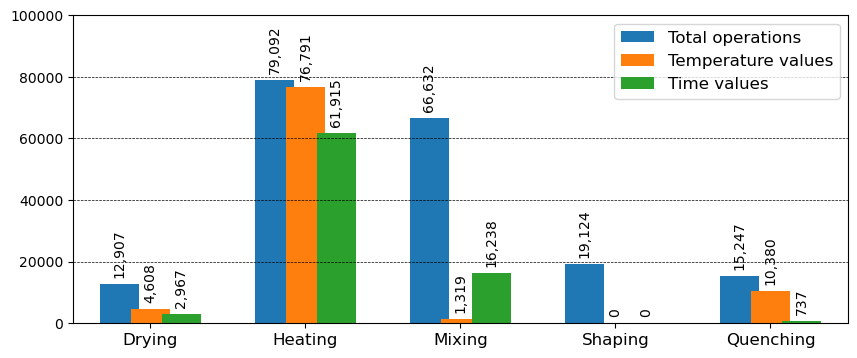

In [266]:
f, ax = plt.subplots(1,1,figsize=(10,4))
for i in range(1,5):
    ax.axhline(20000 * i, ls='--', lw=0.5, color=[0,0,0])
ax.bar(0, 0, color=mpl.cm.tab10(0), label='Total operations')
ax.bar(0, 0, color=mpl.cm.tab10(1), label='Temperature values')
ax.bar(0, 0, color=mpl.cm.tab10(2), label='Time values')
for i, key in enumerate(keys):
    for j, v in enumerate([operations[key], len(temp_vals[key]), len(time_vals[key])]):
        b = ax.bar(i + (j-1) * 0.2, v, width=0.25, color=mpl.cm.tab10(j))
        ax.text(i+(j-1)*0.2, v+2000, f'{v:,d}', rotation=90,
                horizontalalignment='center', verticalalignment='bottom')
    
_ = ax.set_xticks(np.arange(len(keys)), labels=[k.split('Op')[0] for k in keys], fontsize=12)
ax.set_ylim([0, 100000])
ax.legend(loc='upper right', fontsize=12)
ax.set_xlim([-0.5, 4.5])

- Temp. and Time dist.

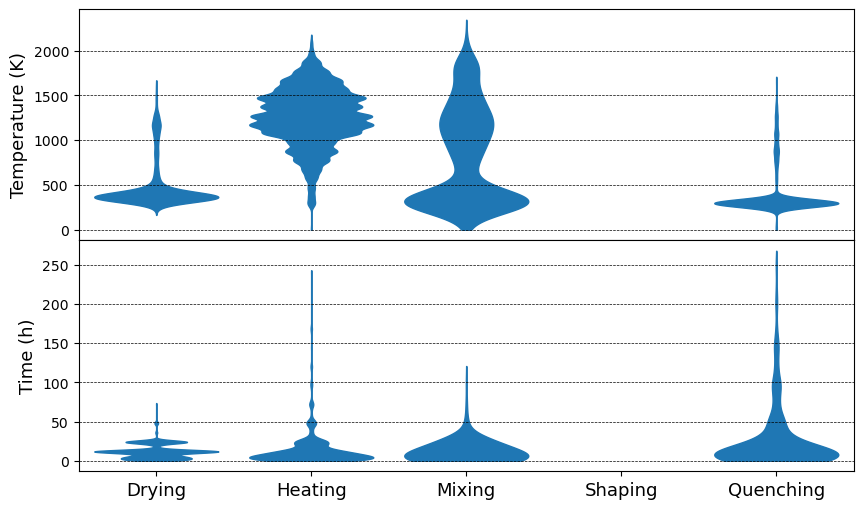

In [278]:
f, ax = plt.subplots(2,1,figsize=(10,6), sharex=True)
y1 = np.linspace(0,3000,3000)
y2 = np.linspace(0,300,3000)
for i, key in enumerate(keys):
    t1 = temp_vals[key]
    t2 = time_vals[key]
    if len(t1) != 0:
        x = gaussian_kde(t1)(y1)
        x = x/np.max(x) * 0.4
        m = x > 1e-3
        ax[0].fill_betweenx(y1[m], -x[m]+i, x[m]+i, color=mpl.cm.tab10(0))
    if len(t2) != 0:
        x = gaussian_kde(t2)(y2)
        x = x/np.max(x) * 0.4
        m = x > 1e-3
        ax[1].fill_betweenx(y2[m], -x[m]+i, x[m]+i, color=mpl.cm.tab10(0))
for _ax in ax: 
    _ax.set_xlim([-0.5, 4.5])
[ax[0].axhline(i*500, ls='--', lw=0.5, color=[0,0,0]) for i in range(5)]
[ax[1].axhline(i*50, ls='--', lw=0.5, color=[0,0,0]) for i in range(6)]
ax[1].set_xticks(np.arange(len(keys)), labels=[k.split('O')[0].split('Syn')[0] for k in keys], fontsize=13)
ax[0].set_ylabel('Temperature (K)', fontsize=13)
ax[1].set_ylabel('Time (h)', fontsize=13)
f.subplots_adjust(hspace=0)

- Heating Op. temp. & time dist.

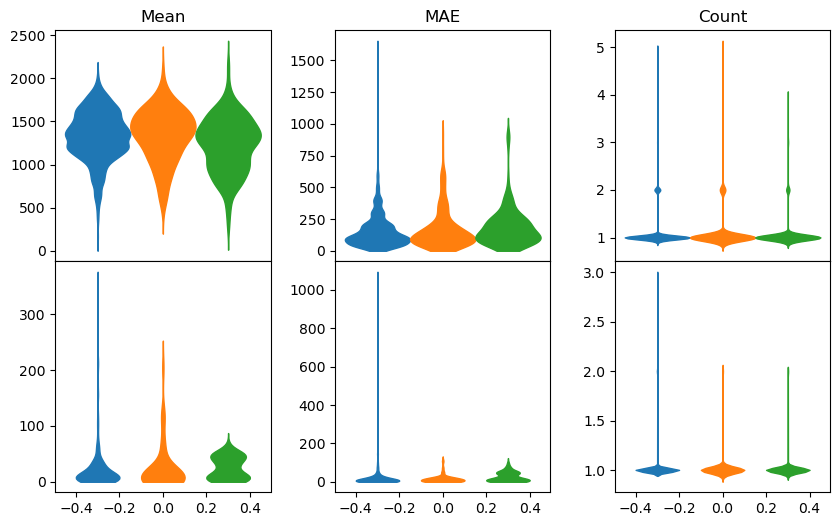

In [206]:
f, axs = plt.subplots(2,3,figsize=(10,6), sharex=True)
for i, ds in enumerate(operations.keys()):
    k = (i-1) * 0.3
    for j, vs in enumerate(np.array(temp_dist[ds]).T):
        y = np.linspace(0,3000,500)
        if j == 2:
            y = np.linspace(0,10,500)
        x = gaussian_kde(vs[vs != 0])(y)
        x = x/np.max(x) * 0.15
        m = x > 1e-4
        axs[0, j].fill_betweenx(y[m], -x[m]+k, x[m]+k, color=mpl.cm.tab10(i))
    for j, vs in enumerate(np.array(time_dist[ds]).T):
        y = np.linspace(0,1500,500)
        if j == 2:
            y = np.linspace(0,10,500)
        x = gaussian_kde(vs[vs != 0])(y)
        x = x/np.max(x) * 0.1
        m = x > 1e-4
        axs[1, j].fill_betweenx(y[m], -x[m]+k, x[m]+k, color=mpl.cm.tab10(i))
axs[0,0].set_title('Mean')
axs[0,1].set_title('MAE')
axs[0,2].set_title('Count')
f.subplots_adjust(hspace=0, wspace=0.3)

## Targets & Precursors

In [11]:
chem_format = '{}={:.3f}'

count_ele = {e:0 for e in sorted(ActiveElements, key=lambda x: Element(x).number)}
count_target = {}
count_target_system = {}
count_prec = {}
count_prec_system = {}
count_tgt_eles = {e:{'count':0, 'case':{}} for e in sorted(MetalElements, key=lambda x: Element(x).number)}
count_tgt_eles.update({'None':{'count':0, 'case':{}}})
count_fg_eles = {}
count_multiple_prec_case = {e:np.zeros(8) for e in sorted(MetalElements, key=lambda x: Element(x).number)}
count_multiple_prec_case.update({'None':np.zeros(8)})
for data in raw_data:
    # get target material in string
    target_comp = {e:v for e,v in sorted(data['target_comp'].items(), key=lambda x: Element(x[0]).number)}
    prec_comps = [{e:v for e,v in sorted(prec_comp.items(), key=lambda x: Element(x[0]).number)} for prec_comp in data['precursor_comp']]
    
    target_string = '_'.join([chem_format.format(e,v) for e,v in target_comp.items() if v > 0.001])
    target_eles = tuple(list(target_comp.keys()))
    if target_string not in count_target.keys():
        count_target[target_string] = 0
    count_target[target_string] += 1
    if target_eles not in count_target_system.keys():
        count_target_system[target_eles] = 0
    count_target_system[target_eles] += 1

    _num_prec = {e:0 for e in target_comp.keys() if e in MetalElements}
    _num_prec.update({'None':0})
    for prec_comp in prec_comps:
        prec_string = '_'.join([chem_format.format(e,v) for e,v in prec_comp.items() if v > 0.001])
        prec_eles = tuple(list(prec_comp.keys()))
        prec_fg_eles = tuple([e for e in prec_comp.keys() if e not in MetalElements])
        prec_fg_comp_string = '_'.join([f'{v:.3f}' for e, v in prec_comp.items() if (e not in MetalElements) and (v > 0.001)])
        prec_metal_eles = [e for e in prec_comp.keys() if e in MetalElements]
        if len(prec_metal_eles) > 1: # if multiple metallic element
            print(prec_comp)
        prec_metal_ele = prec_metal_eles[0] if len(prec_metal_eles) != 0 else 'None'
        
        if prec_string not in count_prec.keys():
            count_prec[prec_string] = 0
        count_prec[prec_string] += 1
        if prec_eles not in count_prec_system.keys():
            count_prec_system[prec_eles] = 0
        count_prec_system[prec_eles] += 1
        if prec_fg_eles not in count_tgt_eles[prec_metal_ele]['case'].keys():
            count_tgt_eles[prec_metal_ele]['case'][prec_fg_eles] = {'count':0, 'case':{}}
        if prec_fg_comp_string not in count_tgt_eles[prec_metal_ele]['case'][prec_fg_eles]['case'].keys():
            count_tgt_eles[prec_metal_ele]['case'][prec_fg_eles]['case'][prec_fg_comp_string] = 0
        count_tgt_eles[prec_metal_ele]['count'] += 1
        count_tgt_eles[prec_metal_ele]['case'][prec_fg_eles]['count'] += 1
        count_tgt_eles[prec_metal_ele]['case'][prec_fg_eles]['case'][prec_fg_comp_string] += 1
        
        if prec_fg_eles not in count_fg_eles.keys():
            count_fg_eles[prec_fg_eles] = {'count':0, 'case':{}}
        if prec_fg_comp_string not in count_fg_eles[prec_fg_eles]['case'].keys():
            count_fg_eles[prec_fg_eles]['case'][prec_fg_comp_string] = {'count':0, 'case':{}}
        if prec_metal_ele not in count_fg_eles[prec_fg_eles]['case'][prec_fg_comp_string]['case'].keys():
            count_fg_eles[prec_fg_eles]['case'][prec_fg_comp_string]['case'][prec_metal_ele] = 0
        count_fg_eles[prec_fg_eles]['count'] += 1
        count_fg_eles[prec_fg_eles]['case'][prec_fg_comp_string]['count'] += 1
        count_fg_eles[prec_fg_eles]['case'][prec_fg_comp_string]['case'][prec_metal_ele] += 1
        
        _num_prec[prec_metal_ele] += 1
    for e, v in _num_prec.items():
        if e == 'None' and v == 0: continue
        count_multiple_prec_case[e][v] += 1

- \# of target & precursors

In [8]:
print('Count by target composition', len(count_target))
print('Count by target element', len(count_target_system))
print('Count by precursor composition', len(count_prec))
print('Count by precursor element', len(count_prec_system))

fg_sys = []
for v in count_tgt_eles.values():
    for k in v['case'].keys():
        if k not in fg_sys:
            fg_sys.append(k)

print('Count by precursor functional group element', len(fg_sys))

Count by target composition 27854
Count by target element 9557
Count by precursor composition 1037
Count by precursor element 665
Count by precursor functional group element 59


- \# of elements in target compounds & precursors

In [150]:
count_target_system.keys()

dict_keys([('N', 'O', 'Al', 'Si', 'Y'), ('O', 'Cr', 'Zr'), ('O', 'Na', 'Si', 'Y'), ('O', 'Fe', 'Ba'), ('O', 'Fe', 'Zn'), ('O', 'Fe', 'Cd'), ('O', 'Fe', 'Zn', 'Cd'), ('O', 'Te', 'Tb'), ('O', 'Nb', 'Te', 'Tl'), ('O', 'Sr', 'Nb', 'Ba'), ('O', 'Fe', 'Zn', 'In'), ('O', 'Ti', 'Zr', 'Pb'), ('O', 'Ca', 'Cu', 'Ba', 'Hg'), ('O', 'Zn', 'Ga'), ('O', 'Zn', 'Ga', 'In'), ('O', 'Zn', 'In'), ('O', 'Mg', 'Nb', 'Pb'), ('O', 'Al', 'Y'), ('O', 'Y', 'Hf'), ('O', 'Ca', 'Ga'), ('O', 'Ga', 'Ge', 'Ba'), ('Ag', 'Cd', 'I'), ('O', 'Mn', 'La', 'Pb'), ('O', 'Ti', 'Mn', 'La', 'Pb'), ('O', 'Ba', 'Ce'), ('O', 'Ba', 'Ce', 'Gd'), ('O', 'V', 'Fe'), ('O', 'V', 'Ag'), ('O', 'Ni', 'Zn'), ('O', 'Y', 'Zr', 'La'), ('O', 'Zr', 'La'), ('O', 'In', 'Ba'), ('O', 'Fe', 'Sr'), ('O', 'Fe', 'Sr', 'Nb'), ('O', 'Fe', 'Nb', 'Ba'), ('O', 'Ti', 'Sr'), ('O', 'Co', 'Ga', 'La'), ('O', 'Co', 'La'), ('Li', 'O', 'P', 'Sc'), ('O', 'Co', 'Cu', 'Sr', 'La'), ('O', 'Ho', 'Bi'), ('O', 'Fe', 'Co', 'Zn'), ('Al', 'Ti', 'Cu'), ('Al', 'Ti', 'Cr'), ('Al', 'Ti

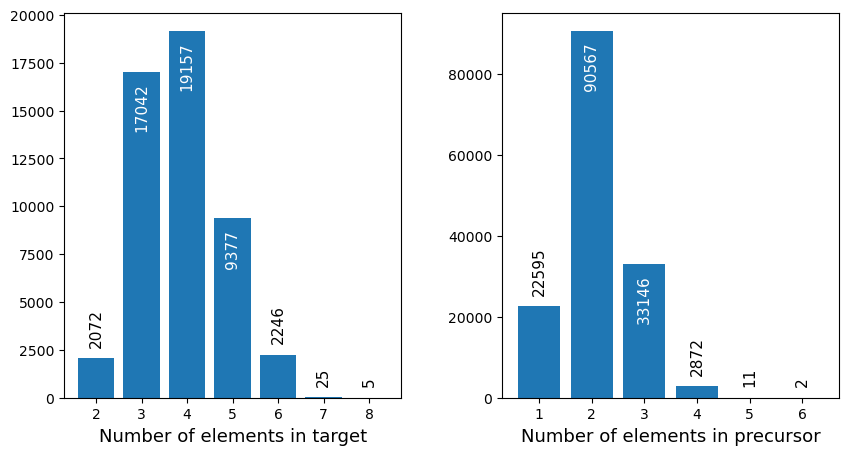

In [209]:
counts = np.zeros((2, 10))
for sys, count in count_target_system.items():
    counts[0, len(sys)] += count
for sys, count in count_prec_system.items():
    counts[1, len(sys)] += count

f, axs = plt.subplots(1,2,figsize=(10,5))
for ax, count in zip(axs, counts):
    b = ax.bar(range(len(count)), count)
    cmax = np.max(count)
    for i, c in enumerate(count):
        if c == 0: continue
        if c < cmax * 0.3:
            ax.text(i, c + cmax*0.03, f'{c:.0f}', rotation=90, fontsize=11, 
                    horizontalalignment='center', verticalalignment='bottom')
        else:
            ax.text(i, c - cmax*0.03, f'{c:.0f}', rotation=90, color=[1,1,1], fontsize=11, 
                    horizontalalignment='center', verticalalignment='top')
axs[0].set_xlabel('Number of elements in target', fontsize=13)
axs[0].set_xlim([1.3,8.7])
axs[1].set_xlabel('Number of elements in precursor', fontsize=13)
axs[1].set_xlim([0.3,6.7])
f.subplots_adjust(wspace=0.3)


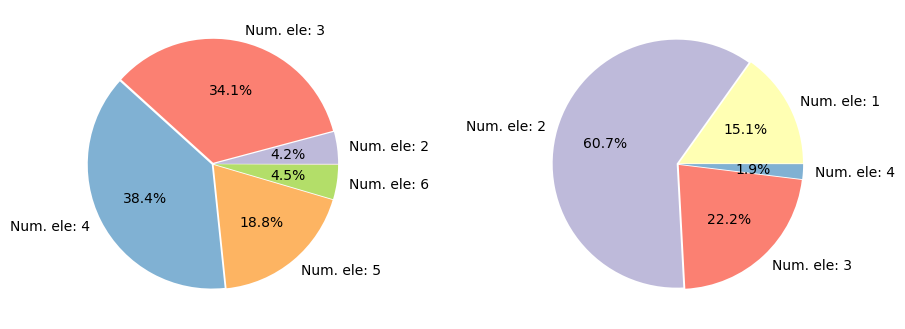

In [248]:
f, axs = plt.subplots(1,2,figsize=(10,5))
_ = axs[0].pie(counts[0], labels=[f'Num. ele: {i}' if counts[0,i] > 1000 else '' for i in range(10)],
           autopct=lambda x: f'{x:.1f}%' if x > 1 else None,
           colors=[mpl.cm.Set3(i) for i in range(12)],
           explode=[0.01]*10,
           )
_ = axs[1].pie(counts[1], labels=[f'Num. ele: {i}' if counts[1,i] > 1000 else '' for i in range(10)],
           autopct=lambda x: f'{x:.1f}%' if x > 1 else None,
           colors=[mpl.cm.Set3(i) for i in range(12)],
           explode=[0.01]*10,
           )
f.subplots_adjust(wspace=0.5)

quatenary가 가장 많음. 

- \# of precursors used for metal element in single reaction

Text(0.5, 0, 'Metal element')

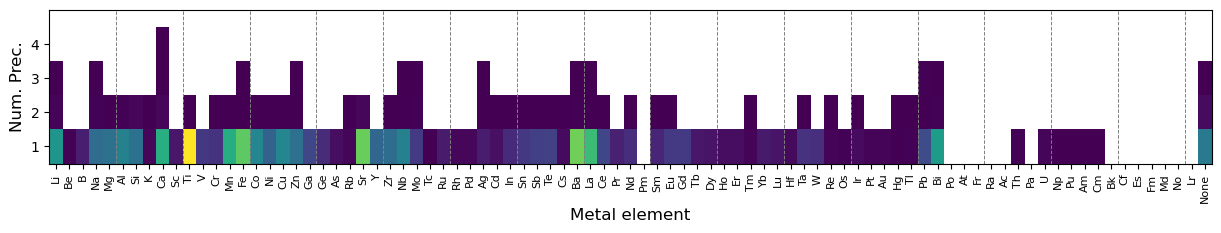

In [7]:
f, ax = plt.subplots(1,1,figsize=(15,2))
cmap = mpl.cm.viridis
cmap.set_under([1,1,1])
ele = list(count_multiple_prec_case.keys())
mat = np.array([v for v in count_multiple_prec_case.values()])
ax.pcolormesh(mat.T, vmin=1, cmap=cmap)
[ax.axvline(i*5, ls='--', color=[0.5, 0.5, 0.5], lw=0.7) for i in range(1,18)]
ax.set_yticks(np.arange(1,5)+0.5, labels=[str(i) for i in range(1,5)])
ax.set_ylim([1, 5.5])
ax.set_xticks(np.arange(len(ele))+0.5, labels=ele, rotation=90, fontsize=8)
ax.set_ylabel('Num. Prec.', fontsize=12)
ax.set_xlabel('Metal element', fontsize=12)
#axs[1].set_ylabel('Valid')
#axs[2].set_ylabel('Train')
#f.subplots_adjust(hspace=0)

In [10]:
for i, v in enumerate(mat.sum(0)):
    if v == 0: continue
    print(f'Num. Prec. used: {i} - count: {v:6.0f}')

Num. Prec. used: 1 - count: 145732
Num. Prec. used: 2 - count:   1573
Num. Prec. used: 3 - count:     97
Num. Prec. used: 4 - count:      6


하나의 원소에 대해 2종 이상의 프리커서가 사용된 경우 존재함

- \# of functional groups (by consisting elements) used for precursors

In [12]:
prec_system = {}
for metal, v in count_tgt_eles.items():
    ele = ('Met',)
    if metal == 'None':
        ele = ('None',)
    for fg_sys, v2 in v['case'].items():
        key = ele + fg_sys
        if key not in prec_system.keys():
            prec_system[key] = 0
        prec_system[key] += v2['count']

prec_system = {k:v for k,v in sorted(sorted(prec_system.items(), key=lambda x: len(x[0])), key=lambda x: x[0][0])}
prec_system_label = np.array(['-'.join(list(k)) for k in prec_system.keys()])
mat = np.array(list(prec_system.values())).reshape(-1,1)
m = np.array(['None' in x for x in prec_system_label])

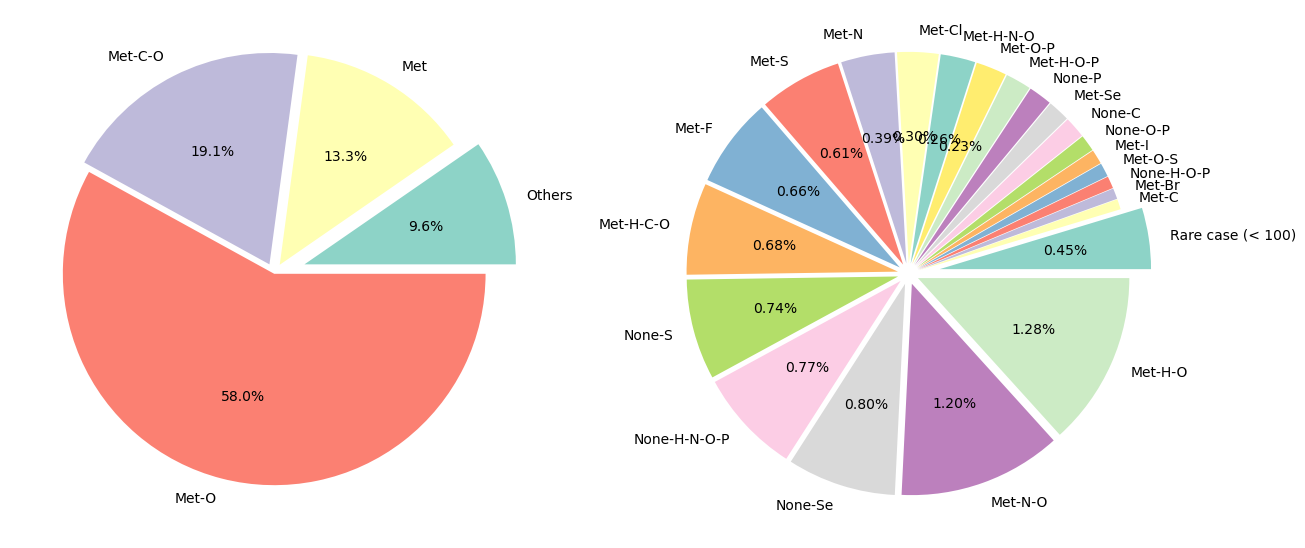

In [13]:
count_all = mat.reshape(-1)
m1 = count_all > 5000
m2 = count_all < 100
major_idx = sorted(np.where(m1)[0], key=lambda x: count_all[x])
minor_idx = sorted(np.where(~m1 & ~m2)[0], key=lambda x: count_all[x])

f, axs = plt.subplots(1, 2, figsize=(15,8))
axs[0].pie([count_all[~m1].sum()] + count_all[major_idx].tolist() , 
           labels=['Others'] + prec_system_label[major_idx].tolist() , 
           colors=[mpl.cm.Set3(i) for i in range(12)],
            autopct='%.1f%%',
            explode=[0.15, 0.05, 0.05, 0]
)
axs[1].pie([count_all[m2].sum()]+count_all[minor_idx].tolist(), 
           labels=['Rare case (< 100)']+prec_system_label[minor_idx].tolist() , 
           colors=[mpl.cm.Set3(i) for i in range(12)],
           autopct=lambda x: f'{x*0.09621765:.2f}%' if x > 2 else None,
           explode=[0.15] + [0.05] * len(minor_idx)
)
f.subplots_adjust(wspace=0.2)

In [256]:
count_all[~m1].sum() / count_all.sum()

0.0962176509621765

In [232]:
n1, n2 = np.sum([n for k,n in prec_system.items() if 'None' in k]), np.sum([n for k,n in prec_system.items() if 'None' not in k])
n1, n2, n1/(n1+n2), n2/(n1+n2), n1+n2

(4643, 144550, 0.031120763038480357, 0.9688792369615197, 149193)

- by log scale

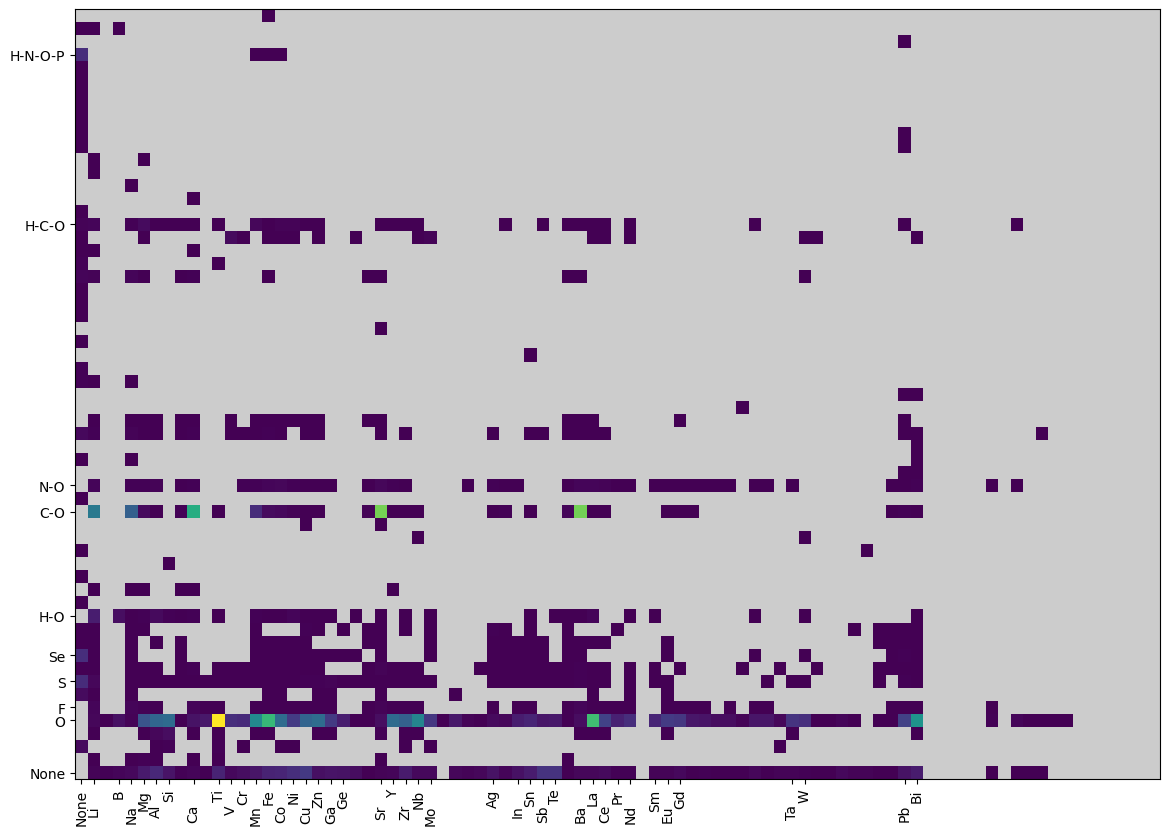

In [8]:
metals = ['None']
metals += list(count_tgt_eles.keys())[:-1]
fg_sys = [tuple()]
fg_sys += sorted(sorted(set([k[1:] for k in prec_system.keys() if len(k) > 1]), key=lambda x: Element(x[0]).number), key=lambda x:len(x))

mat = np.zeros((len(metals), len(fg_sys)))
for i, m in enumerate(metals):
    c = count_tgt_eles.get(m)
    if c is None: continue
    for j, fg in enumerate(fg_sys):
        if c['case'].get(fg) is None:
            continue
        count = c['case'].get(fg)['count']
        mat[i, j] += count

cmap = mpl.cm.viridis
cmap.set_under([0.8,0.8,0.8])
ylabels = ['train','valid','test']
yticks = ['-'.join(list(k)) for k in fg_sys]
yticks[0] = 'None'
f, ax = plt.subplots(1,1,figsize=(14,10))
ax.pcolormesh(mat.T, vmin=1, cmap=cmap)
y_mask = mat.sum(0) > np.sum(mat) * 0.005
ax.set_yticks(np.where(y_mask)[0] + 0.5, labels=np.array(yticks)[y_mask])
x_mask = mat.sum(1) > np.sum(mat) * 0.005
ax.set_xticks(np.where(x_mask)[0] + 0.5, labels=np.array(metals)[x_mask], rotation=90)
for i, t in enumerate(ax.get_xticklabels()):
    if i % 2 == 0: continue
    t.set_y(-0.02)

### frequency-based precursor information

In [22]:
# TODO: make frequency dictionary for recommendation
precursor_usage_freqeuncy = {}
functionalgroup_usage_frequency = {}
total_precursor_used = np.sum([np.sum(v['count']) for v in count_tgt_eles.values()])

for metal, prec_info in count_tgt_eles.items():
    total_metal_used = np.sum(prec_info['count'])
    for func_group, func_info in prec_info['case'].items():
        total_func_used = np.sum(func_info['count'])
        for comp, count in func_info['case'].items():
            pass
#functional_group_info['case']
metal, total_metal_used, func_group, total_func_used, comp, count


('None', 4643, ('H', 'C', 'S', 'Br'), 4, '0.643_0.214_0.071_0.071', [0, 0, 4])

In [62]:
parsed_data['train_reactions'][0]

{'id': 11283,
 'raw_index': 7992,
 'synthesis_type': 'solid_state_ceramic_synthesis',
 'doi': '10.1007/bf00549308',
 'year': 1979,
 'prototype_path': ['AllMaterials/oxides/quaternary/Others/Misc/Y0.00200057Al0.05487283Si0.37153473N0.51443273O0.05715919/Y0.00200057Al0.05487283Si0.37153473N0.51443273O0.05715919'],
 'count_weight': 1.0,
 'target_comp': {'Y': 0.0020005717,
  'Al': 0.054872826,
  'Si': 0.37153473,
  'N': 0.5144327,
  'O': 0.057159193},
 'precursor_comp': [{'Y': 0.4, 'O': 0.6},
  {'Si': 0.33333334, 'O': 0.6666667},
  {'Al': 0.5, 'N': 0.5},
  {'Si': 0.42857143, 'N': 0.5714286}],
 'operations': []}

## Temperature-materials correlation (TODO)

- precursor combinations

In [14]:
high_freq_data = [d for d in sorted(unique_data, key=lambda x: x['count']) if d['count'] > 100]
len(high_freq_data)

13

In [15]:
j = 11
print({k:v*7 for k,v in high_freq_data[j]['target_comp'].items()})
print([p['count'] for p in high_freq_data[j]['precursor_comp']])

{'Li': 1.0000000447034836, 'Mn': 2.000000089406967, 'O': 4.000000178813934}
[62, 53, 39, 87, 7, 1, 3, 1, 3, 10, 2, 6, 5, 1, 1, 4, 4, 3, 1, 4, 2, 1, 14, 1, 1, 1, 1, 1, 1]


In [19]:
p['comp']

[{'Li': 0.2, 'C': 0.2, 'O': 0.6}, {'Mn': 0.33333334, 'O': 0.6666667}]

In [24]:
p

{'count': 87,
 'years': [1998,
  1999,
  1999,
  1999,
  1999,
  1999,
  1999,
  1999,
  2001,
  2001,
  2001,
  2001,
  2001,
  2001,
  2001,
  2001,
  2001,
  2002,
  2002,
  2003,
  2003,
  2003,
  2003,
  2004,
  2004,
  2004,
  2005,
  2005,
  2006,
  2006,
  2006,
  2006,
  2006,
  2007,
  2007,
  2007,
  2007,
  2007,
  2008,
  2008,
  2008,
  2009,
  2010,
  2010,
  2010,
  2010,
  2010,
  2010,
  2011,
  2011,
  2011,
  2011,
  2011,
  2011,
  2012,
  2012,
  2012,
  2012,
  2013,
  2013,
  2013,
  2013,
  2014,
  2014,
  2014,
  2014,
  2014,
  2014,
  2015,
  2015,
  2015,
  2015,
  2015,
  2016,
  2016,
  2016,
  2016,
  2016,
  2017,
  2018,
  2018,
  2018,
  2018,
  2018,
  2018,
  2018,
  2019],
 'comp': [{'Li': 0.33333334, 'C': 0.16666667, 'O': 0.5},
  {'Mn': 0.33333334, 'O': 0.6666667}],
 'heat_temp': [1073.15,
  1173.15,
  1073.15,
  1070.0,
  820.0,
  998.15,
  998.15,
  773.15,
  1123.15,
  1023.15,
  1123.15,
  1063.15,
  1073.15,
  723.15,
  1123.15,
  1123.15,
  

In [56]:
tuple([tuple([1,2]), tuple([2,3])])

((1, 2), (2, 3))

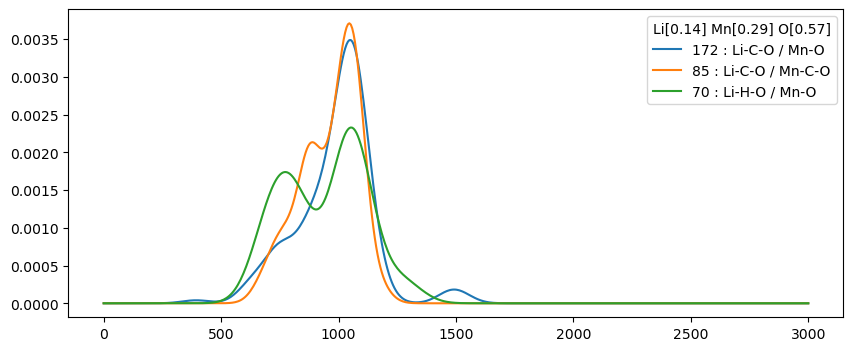

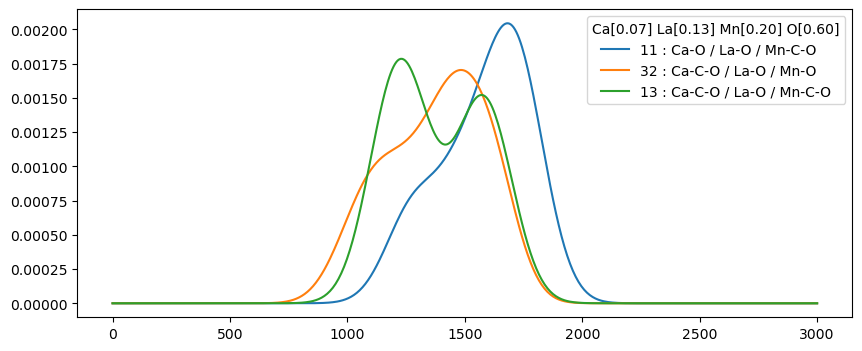

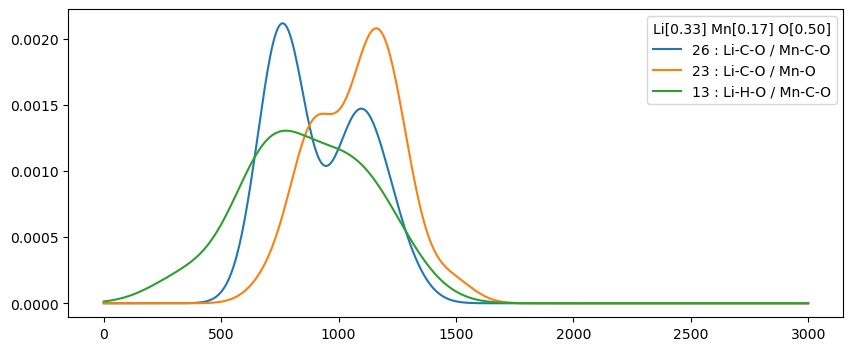

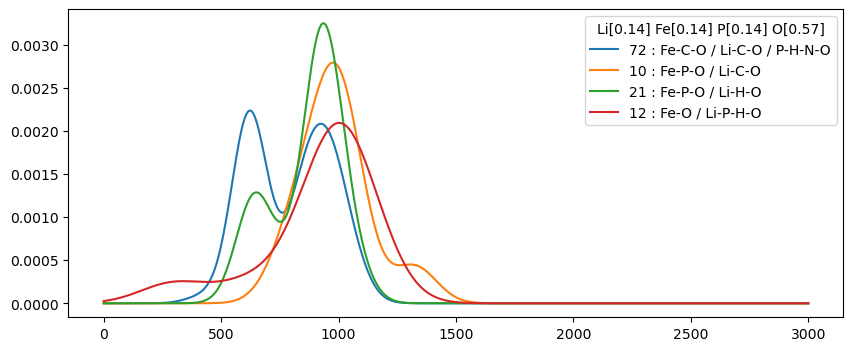

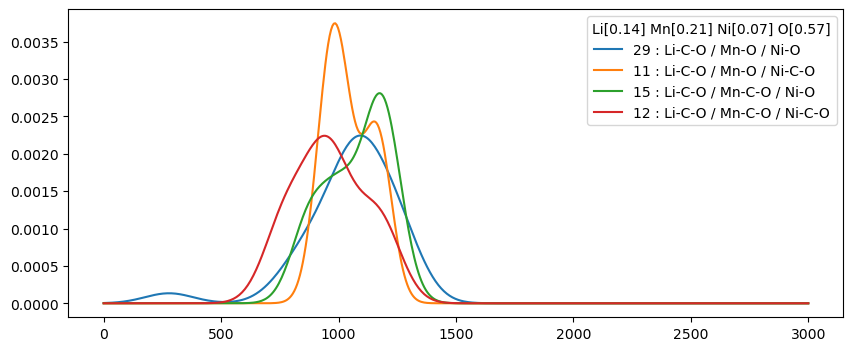

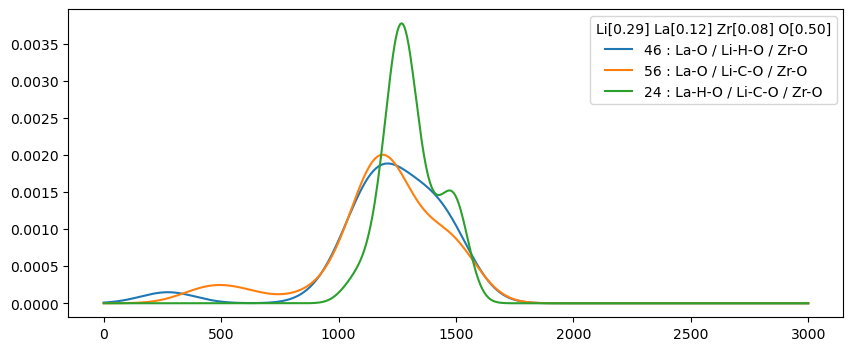

In [81]:
mul = 1
for j in range(len(unique_data)):
    target_comp = ' '.join([f'{k}[{v*mul:.2f}]' for k,v in unique_data[j]['target_comp'].items()])
    x = np.linspace(0,3000,500)
    prec_collections = {}
    for prec_comp in unique_data[j]['precursor_comp']:
        key = tuple([tuple(list(p.keys())) for p in sorted(prec_comp['comp'], key=lambda x: tuple(list(x.keys())))])
        if key not in prec_collections.keys():
            prec_collections[key] = []
        prec_collections[key].extend(prec_comp['heat_temp'])
    #prec_comp['comp']
    if len([v for v in prec_collections.values() if len(v) > 10]) < 3:
        continue

    f, ax = plt.subplots(1,1,figsize=(10,4))
    for comp, temp in prec_collections.items():
        c = ' / '.join(['-'.join(list(c)) for c in comp])
        if len(temp) < 10:
            continue
        g = gaussian_kde(temp)
        ax.plot(x, g(x), label =f'{len(temp)} : {c}')
    ax.legend(loc='upper right', title=target_comp)


- all precursors

In [35]:
prec_vecs = np.zeros((1,104))
prec_heat_data = []
for i, data in enumerate(raw_data):
    for prec in data['precursor_comp']:
        prec_vec = composition_to_feature(prec)
        dist = np.abs(prec_vecs - prec_vec).sum(1)
        is_unique = np.sum(dist < 1e-5) == 0
        if is_unique:
            prec_vecs = np.vstack([prec_vec, prec_vecs])
            prec_heat_data.append({
                'comp':prec,
                'temp':[],
                'time':[],
            })
            j = -1
        else:
            j = np.argmin(dist)
        for op in data['operations']:
            if not op['type'].startswith('Heating'): continue
            for t in op['attributes']['temperature']:
                prec_heat_data[j]['temp'].extend(t['values'])
            for t in op['attributes']['time']:
                prec_heat_data[j]['time'].extend(t['values'])
    print(i, len(prec_heat_data), end='\r')

In [64]:
prec_heat_data = [d for d in sorted(prec_heat_data, key=lambda x: tuple(list(x['comp'].values())))]
prec_heat_data = [d for d in sorted(prec_heat_data, key=lambda x: tuple(list(x['comp'].keys())))]
prec_heat_data = [d for d in sorted(prec_heat_data, key=lambda x: len(x['comp'].keys()))]

def comp_to_string(comp):
    x = []
    for e, f in comp.items():
        fs = f'{f:.3f}'
        x.append(f'{e}[{fs}]')
    return ' '.join(x)

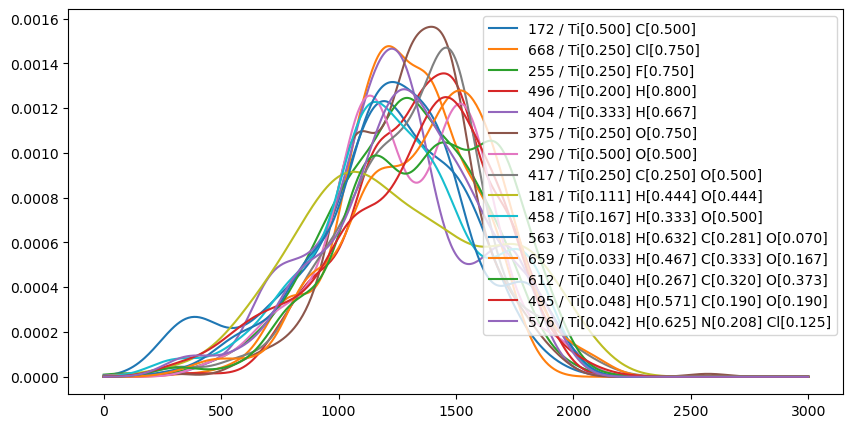

In [69]:
#view_eles = ['Ti', 'Sr', 'Ba', 'Fe', 'La', 'Ca', 'Mn', 'Bi', 'Li']
#view_eles = ['Ni','Pb','Ce','Ga','Te','Sb','Mo','Eu','Gd',]
view_eles = ['Ti']
x = np.linspace(0,3000,500)
#mat_by_prec = {k:v for k,v in sorted(mat_by_prec.items(), key=lambda x: x[1]['count'], reverse=True)}
for ele in view_eles:
    f, ax = plt.subplots(1,1,figsize=(10,5))
    for data in prec_heat_data:
        if ele not in data['comp'].keys(): continue
        if len(data['temp']) < 100: continue
#        if len(data['temp']) < 10: continue
        g = gaussian_kde(data['temp'])
        ax.plot(x, g(x), label=f'{len(data["temp"])} / {comp_to_string(data["comp"])}')
    ax.legend(loc='upper right')